In [1022]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1023]:
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd

import pandapower as pp
import random
import math
import geopandas as gpd

import re

In [1024]:
micropolis_folder = Path('../../infrarisk/data/networks/micropolis/gis')

# Micropolis Power Network Generation
## Buses

In [1025]:
micropolis_allbuses = gpd.read_file(micropolis_folder/'all_buses.shp', encoding="utf-8")
micropolis_buses = micropolis_allbuses[micropolis_allbuses.layer != 'Substation buses']
micropolis_buses['x'] = micropolis_buses.centroid.x
micropolis_buses['y'] = micropolis_buses.centroid.y

bus_vn_kv_dict = {'Feeder1 buses': 13.8,
                  'Overhead distribution buses': 13.8,
                  'Feeder2_buses': 13.8,
                  'Underground distribution buses': 13.8,
                  }

micropolis_buses["vn_kv"] = micropolis_buses["layer"].apply(lambda x: bus_vn_kv_dict.get(x))

del micropolis_buses['path']
del micropolis_buses['geometry']
#micropolis_buses.FID = micropolis_buses.FID.astype(int)
micropolis_buses.head()

C:\Users\srijith\AppData\Local\Temp/ipykernel_15268/2853046007.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  micropolis_buses['x'] = micropolis_buses.centroid.x
C:\Users\srijith\AppData\Local\Temp/ipykernel_15268/2853046007.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  micropolis_buses['y'] = micropolis_buses.centroid.y


,FID,layer,Switches,x,y,vn_kv
0,54,Feeder1 buses,49,5426.421856,4000.618975,13.8
1,55,Feeder1 buses,49,5209.765439,3997.432851,13.8
2,56,Feeder1 buses,49,4967.620031,4003.805099,13.8
3,0,Feeder1 buses,"268,5,SS",4887.568671,3218.823850,13.8
4,1,Feeder1 buses,"268,5,SS",4787.205771,3218.823850,13.8


In [1026]:
pn = pp.create_empty_network(
    name="sample_network", f_hz=50.0, sn_mva=1, add_stdtypes=True
)

In [1027]:
buses = dict()
for index, row in micropolis_buses.iterrows():
    x, y = row.x, row.y
    buses[f'bus{row.FID}'] = pp.create_bus(pn, vn_kv=row['vn_kv'], name=f'P_B{row.FID}', geodata=(x, y), type="b")
    
#Substation bus
buses[f'bus_Substation_ext'] = pp.create_bus(pn, vn_kv = 138, name=f'P_B1000', geodata=(4911,3250), type="b")
buses[f'bus_Substation'] = pp.create_bus(pn, vn_kv = 13.8, name=f'P_B1001', geodata=(4911,3180), type="b")

In [1028]:
pn.bus.tail()

,name,vn_kv,type,zone,in_service
373,P_B383,13.8,b,None,True
374,P_B384,13.8,b,None,True
375,P_B385,13.8,b,None,True
376,P_B1000,138.0,b,None,True
377,P_B1001,13.8,b,None,True


###  External grid

In [1029]:
ext_grids = dict()

pn.ext_grid_geodata = pd.DataFrame(columns = ['x', 'y'])
ext_grids['ext_grid1'] = pp.create_ext_grid(pn, buses['bus_Substation_ext'], name="P_EG1", s_sc_max_mva=1000, rx_max=.1, x0x_max=1.0, r0x0_max=0.1)
pn.ext_grid_geodata = pn.ext_grid_geodata.append({'x': 4911, 'y': 3325}, ignore_index = True)

## Lines, Transformers, and Switches

In [1030]:
micropolis_links = gpd.read_file(micropolis_folder/'combined_lines.shp', encoding="utf-8")
micropolis_links.id = micropolis_links.id.values.astype(int)

### Lines

In [1031]:
micropolis_lines = micropolis_links[micropolis_links.layer.isin(['Feeder1_lines', 'Feeder2_lines', 'Overhead lines', 'Underground lines'])]
micropolis_lines.head()

,id,from,to,Voltage,layer,path,sublayer,geometry
0,1,0,1,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4887.569 3218.824, 4787.206 3218.824)"
1,2,1,2,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4787.206 3218.824, 4784.020 3402.026)"
2,3,2,3,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4784.020 3402.026, 4785.613 3601.159)"
3,4,3,4,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4785.613 3601.159, 4787.206 3766.837)"
6,7,6,7,13.8 KV,Feeder1_lines,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4788.799 4212.894, 4785.613 4421.586)"


In [1032]:
def compute_distance(bus1, bus2):
    x1 = micropolis_buses[micropolis_buses.FID == int(bus1)].x.item()
    x2 = micropolis_buses[micropolis_buses.FID == int(bus2)].x.item()
    y1 = micropolis_buses[micropolis_buses.FID == int(bus1)].y.item()
    y2 = micropolis_buses[micropolis_buses.FID == int(bus2)].y.item()
    dist = math.hypot(x2 - x1, y2 - y1)/1000
    return dist

In [1033]:
pp.create_std_type(pn, {'c_nf_per_km': 210, 
                        'r_ohm_per_km': 0.642,
                        'x_ohm_per_km': 0.083, 
                        'max_i_ka': 0.142,
                        'type': 'ol'}, 
                     name="micropolis_line")

micropolis_line = 'micropolis_line'
#micropolis_line  = '15-AL1/3-ST1A 0.4'

In [1034]:
for i, row in micropolis_lines.iterrows():
    pp.create_line(pn, 
                    from_bus = buses['bus{}'.format(row['from'])], 
                    to_bus = buses['bus{}'.format(row['to'])], 
                    length_km = compute_distance(row['from'], row['to']), 
                    std_type=micropolis_line, 
                    name= 'P_L{}'.format(row['id']), 
                    #index = i,
                    )

In [1035]:
pn.line.head()

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,P_L1,micropolis_line,3,4,0.100363,0.642,0.083,210.0,0.0,0.142,1.0,1,ol,True
1,P_L2,micropolis_line,4,5,0.183230,0.642,0.083,210.0,0.0,0.142,1.0,1,ol,True
2,P_L3,micropolis_line,5,6,0.199139,0.642,0.083,210.0,0.0,0.142,1.0,1,ol,True
3,P_L4,micropolis_line,6,7,0.165686,0.642,0.083,210.0,0.0,0.142,1.0,1,ol,True
4,P_L7,micropolis_line,9,10,0.208715,0.642,0.083,210.0,0.0,0.142,1.0,1,ol,True


### Switches

In [1036]:
micropolis_switches = micropolis_links[micropolis_links.layer == 'Switches']
micropolis_switches.head()

,id,from,to,Voltage,layer,path,sublayer,geometry
4,5,4,5,13.8 KV,Switches,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4787.206 3766.837, 4785.613 4001.814)"
5,6,5,6,13.8 KV,Switches,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4785.613 4001.814, 4788.799 4212.894)"
8,9,8,9,13.8 KV,Switches,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4785.613 4617.532, 4785.613 4797.548)"
12,16,9,10,13.8 KV,Switches,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4785.613 4797.548, 4587.277 4796.752)"
13,20,9,25,13.8 KV,Switches,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (4785.613 4797.548, 5014.217 4795.159)"


In [1037]:
switches = dict()
for i, row in micropolis_switches.iterrows():
    #print(row)
    #create switch buses
    switch_bus = micropolis_buses[micropolis_buses['FID'] == int(row['from'])]
    #print(switch_bus)
    buses['busS{}'.format(row['from'])] = pp.create_bus(pn, 
                                                vn_kv=switch_bus['vn_kv'], 
                                                name='P_B{}S'.format(row['id']), 
                                                geodata=(switch_bus.x.item(), switch_bus.y.item()), 
                                                type="b")
    
    #create switches
    switches['switch{}'.format(row.id)] = pp.create_switch(
        pn, 
        buses['bus{}'.format(row['from'])], 
        buses['busS{}'.format(row['from'])], 
        et="b", 
        type="CB", 
        closed=True, 
        name="P_S{}".format(row['id'])
    )

    #switch_bus to bus line
    pp.create_line(pn, 
                    from_bus = buses['busS{}'.format(row['from'])], 
                    to_bus = buses['bus{}'.format(row['to'])], 
                    length_km = compute_distance(row['from'], row['to']), 
                    std_type=micropolis_line, 
                    name= 'P_L{}S'.format(row['id']),
                    )
#Substation breakers
switches['switch_Feeder1'] = pp.create_switch(
        pn, 
        buses['bus_Substation'], 
        buses['bus0'], 
        et="b", 
        type="CB", 
        closed=True,
        name="P_S2001"
)
switches['switch_Feeder2'] = pp.create_switch(
        pn, 
        buses['bus_Substation'], 
        buses['bus60'], 
        et="b", 
        type="CB", 
        closed=True, 
        name="P_S2002"
)

In [1038]:
pn.switch.head()

,bus,element,et,type,closed,name,z_ohm
0,7,378,b,CB,True,P_S5,0.0
1,8,379,b,CB,True,P_S6,0.0
2,11,380,b,CB,True,P_S9,0.0
3,12,381,b,CB,True,P_S16,0.0
4,12,382,b,CB,True,P_S20,0.0


In [1039]:
micropolis_offswitches = micropolis_links[micropolis_links.layer == 'Off Switch']
micropolis_offswitches.head()

,id,from,to,Voltage,layer,path,sublayer,geometry
27,36,40,41,13.8 KV,Off Switch,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,9.0,"LINESTRING (5589.312 4227.232, 5590.905 3997.831)"
280,297,73,13,None,Off Switch,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (3794.330 4796.353, 3989.878 4796.752)"
313,330,321,322,None,Off Switch,C:/Users/srijith/Dropbox/Intra-CREATE Seed Gra...,NaN,"LINESTRING (1809.375 3998.229, 1569.969 3998.8..."


In [1040]:
for i, row in micropolis_offswitches.iterrows():

    #create switch buses
    switch_bus = micropolis_buses[micropolis_buses['FID'] == int(row['from'])]
    buses['busS{}'.format(row['from'])] = pp.create_bus(pn, 
                                                vn_kv=switch_bus['vn_kv'], 
                                                name='P_B{}S'.format(row['id']), 
                                                geodata=(switch_bus.x.item(), switch_bus.y.item()), 
                                                type="b")
    
    #create switches
    switches['switch{}'.format(row.id)] = pp.create_switch(
        pn, 
        buses['bus{}'.format(row['from'])], 
        buses['busS{}'.format(row['from'])], 
        et="b", 
        type="CB", 
        closed=False, 
        name="P_S{}".format(row['id'])
    )

    #switch_bus to bus line
    pp.create_line(pn, 
                    from_bus = buses['busS{}'.format(row['from'])], 
                    to_bus = buses['bus{}'.format(row['to'])], 
                    length_km = compute_distance(row['from'], row['to']), 
                    std_type=micropolis_line, 
                    name= 'P_L{}S'.format(row['id']),
                    )

## Loads

In [1041]:
micropolis_buildings = gpd.read_file(micropolis_folder/'buildings_v1.shp', encoding="utf-8")
print(micropolis_buildings.shape)
micropolis_buildings.head(2)

(868, 12)


,FACILITY_T,AREA,OHC,EF,CCN,HEIGHT,POP,ID,BUILDING_C,Category,Centroid,geometry
0,Single Family Re,1502.34,7,1.5,1.0,14.0,1,1,114177.84,None,"3852,4329","POLYGON ((3870.889 4364.112, 3870.782 4349.179..."
1,Single Family Re,1534.68,7,1.5,1.0,14.0,1,2,116635.68,None,"3266,4061","POLYGON ((3240.796 4076.466, 3291.150 4076.466..."


In [1042]:
micropolis_hub_dist = gpd.read_file(micropolis_folder/'Hub distance.shp', encoding="utf-8")
micropolis_hub_dist1 = micropolis_hub_dist.loc[:, ['ID', 'HubName', 'HubDist']]

In [1043]:
micropolis_buildings= pd.merge(micropolis_buildings, micropolis_hub_dist1, left_on = 'ID', right_on = 'ID', how = 'inner')
#del micropolis_buildings['geometry']
print(micropolis_buildings.shape)
micropolis_buildings.head(2)

(802, 14)


,FACILITY_T,AREA,OHC,EF,CCN,HEIGHT,POP,ID,BUILDING_C,Category,Centroid,geometry,HubName,HubDist
0,Single Family Re,1502.34,7,1.5,1.0,14.0,1,1,114177.84,None,"3852,4329","POLYGON ((3870.889 4364.112, 3870.782 4349.179...",347,97.180446
1,Single Family Re,1534.68,7,1.5,1.0,14.0,1,2,116635.68,None,"3266,4061","POLYGON ((3240.796 4076.466, 3291.150 4076.466...",317,100.337214


In [1044]:
micropolis_power_details = pd.read_csv(micropolis_folder/'building_power_details.csv')
micropolis_power_details.head()

,building,type,Pabc,Qabc,voltage,phases
0,Apartment,Residential,90,0,120,1
1,Auto Parts Resel,Industrial,30,0,208,3
2,Bar,CBD,30,0,208,3
3,Bookstore,CBD,30,0,208,3
4,Church,Church,250,0,208,3


In [1045]:
micropolis_power_details.voltage.unique()

array([ 120,  208, 3300, 1200], dtype=int64)

In [1046]:
micropolis_buildings= pd.merge(micropolis_buildings, micropolis_power_details, left_on = 'FACILITY_T', right_on = 'building', how = 'inner')
del micropolis_buildings['building']
print(micropolis_buildings.shape)
micropolis_buildings.head()

(788, 19)


,FACILITY_T,AREA,OHC,EF,CCN,HEIGHT,POP,ID,BUILDING_C,Category,Centroid,geometry,HubName,HubDist,type,Pabc,Qabc,voltage,phases
0,Single Family Re,1502.34,7,1.5,1.0,14.0,1,1,114177.84,None,"3852,4329","POLYGON ((3870.889 4364.112, 3870.782 4349.179...",347,97.180446,Residential,20,0,120,1
1,Single Family Re,1534.68,7,1.5,1.0,14.0,1,2,116635.68,None,"3266,4061","POLYGON ((3240.796 4076.466, 3291.150 4076.466...",317,100.337214,Residential,20,0,120,1
2,Single Family Re,1512.22,7,1.0,1.0,14.0,2,3,114928.72,None,"3543,4082","POLYGON ((3525.126 4101.208, 3565.210 4101.155...",316,NaN,Residential,20,0,120,1
3,Single Family Re,1502.34,7,1.0,1.0,14.0,6,4,114177.84,None,"3399,4345","POLYGON ((3380.307 4310.097, 3380.549 4325.028...",325,102.018284,Residential,20,0,120,1
4,Single Family Re,1502.34,7,1.0,1.0,14.0,5,5,114177.84,None,"3249,4504","POLYGON ((3267.023 4539.468, 3267.034 4524.535...",325,114.257383,Residential,20,0,120,1


In [1047]:
switch_list = list(micropolis_buses.Switches.unique())
#phase_list = [1,2,3]
phase_loads = [0,0,0]
phase_dict = dict()

for switch_comb in switch_list:
    #print(switch_comb)
    #phase_dict[switch] = secrets.choice(phase_list)
    buses_using_switch_comb = list(micropolis_buses[micropolis_buses['Switches'] == switch_comb]['FID'].unique())
    buses_using_switch_comb = [str(bus) for bus in buses_using_switch_comb]
    #print(buses_using_switch_comb)
    buildings_using_switch_comb_1p = micropolis_buildings.loc[(micropolis_buildings['HubName'].isin(buses_using_switch_comb)) & (micropolis_buildings['phases'] == 1), :]
    #print(buildings_using_switch_comb_1p)
    tot_load_on_switch_comb = buildings_using_switch_comb_1p['Pabc'].sum()
    #print(tot_load_on_switch_comb)

    phase_to_load = phase_loads.index(min(phase_loads))
    phase_loads[phase_to_load] += tot_load_on_switch_comb
    phase_dict[switch_comb] = phase_to_load

print(phase_loads)
print(phase_dict)

[5690, 5200, 5870]
{'49': 0, '268,5,SS': 0, '6,49,5': 1, '6,9,269': 1, '16,307,20,9': 1, '303,16': 1, '307': 2, '20,23': 0, '24,288,33,23': 1, '24': 1, '33,285,284': 0, '33,285': 0, '268': 0, '267': 1, '266': 0, '60,SS,299': 2, '60,SS': 2, '300,60,61,305': 2, '61,64,301': 2, '61,64': 2, '65,302,64,303': 2, '303,297': 2, '65': 2, '394': 1, '270': 2, '308': 2, '272': 2, '271': 2, '274': 2, '273': 2, '276': 2, '277': 2, '278': 2, '280': 2, '283': 2, '284': 2, '286': 0, '287': 2, '269,285': 1, '288': 0, '289': 1, '290': 2, '291': 0, '292': 1, '293': 2, '294': 0, '295': 1, '296': 2, '304': 0, '279': 1, '281': 1, '282': 1, '275': 1, '298': 1, '299': 0, '300': 1, '301': 0, '302': 2, '305': 1, '385': 1, '386': 1}


In [1048]:
micropolis_buildings.Pabc.sum()

23930

In [1049]:
pn.loads_geodata = pd.DataFrame(columns = ['x', 'y'])

In [1050]:
sym_loads = dict()

for i, row in micropolis_buildings.iterrows():
    coord = row['Centroid']
    x, y = coord.split(',')
    x, y = float(x), float(y)

    load_switch = micropolis_buses[micropolis_buses.FID == int(row['HubName'])].Switches.item()
    phase = phase_dict[load_switch]

    buses[f'busL{row.ID}'] = pp.create_bus(pn, 
                                          vn_kv=row['voltage']/1000, 
                                          name=f'P_B{row.ID}L', 
                                          geodata=(x, y), 
                                          type="b")

    pp.create_transformer_from_parameters(pn, 
                                        hv_bus=buses[f'bus{row.HubName}'], 
                                        lv_bus=buses[f'busL{row.ID}'], 
                                        sn_mva= 1.2*row['Pabc'], 
                                        vn_hv_kv= 13.8, 
                                        vn_lv_kv= row['voltage']/1000, 
                                        vk_percent= 10.1, 
                                        vkr_percent= 0.266, 
                                        pfe_kw= 0, 
                                        i0_percent= 0.05, 
                                        shift_degree= 150, 
                                        tap_side= 'hv',
                                        tap_neutral= 0,
                                        tap_min= -2, 
                                        tap_max= 2,
                                        tap_step_degree= 0,
                                        tap_step_percent= 2.5,
                                        tap_phase_shifter= False,
                                        index=pp.get_free_id(pn.trafo)+1,
                                        name = "P_TF{}".format(row.ID)
                                      )
    
    pp.create_load(pn, 
                    buses[f'busL{row.ID}'], 
                    p_mw=row['Pabc']/1000, 
                    q_mvar= 0.2 * row['Pabc']/1000, 
                    name='P_LO{}'.format(row['ID']))
    pn.loads_geodata = pn.loads_geodata.append({'x': x, 'y': y}, ignore_index = True)
        
pp.create_transformer_from_parameters(pn, 
                                      hv_bus=buses['bus_Substation_ext'], 
                                      lv_bus=buses['bus_Substation'], 
                                      sn_mva= 25*1.2, 
                                      vn_hv_kv= 138, 
                                      vn_lv_kv= 13.8, 
                                      vk_percent= 12, 
                                      vkr_percent= 0.41, 
                                      pfe_kw= 14, 
                                      i0_percent= 0, 
                                      shift_degree= 150, 
                                      tap_side= 'hv',
                                      tap_neutral= 0,
                                      tap_min= -9, 
                                      tap_max= 9,
                                      tap_step_degree= 0,
                                      tap_step_percent= 1.5,
                                      tap_phase_shifter= False,
                                      index=pp.get_free_id(pn.trafo)+1,
                                      name = "P_TF0"
                                    )

1577

In [1051]:
# Pump
pumps = dict()
pp.create_motor(pn, buses['busL78'], pn_mech_mw=0.23, cos_phi=0.8, name="P_MP1")
pp.create_motor(pn, buses['busL78'], pn_mech_mw=0.23, cos_phi=0.8, name="P_MP2")
pp.create_motor(pn, buses['busL78'], pn_mech_mw=0.23, cos_phi=0.8, name="P_MP3")

pn.pumps_geodata = pd.DataFrame(columns = ['x', 'y'])
pn.pumps_geodata = pn.pumps_geodata.append({'x': 3440, 'y': 6350}, ignore_index = True)
pn.pumps_geodata = pn.pumps_geodata.append({'x': 3465, 'y': 5870}, ignore_index = True)
pn.pumps_geodata = pn.pumps_geodata.append({'x': 3380, 'y': 5895}, ignore_index = True)

In [1052]:
pp.diagnostic(pn)



_____________ PANDAPOWER DIAGNOSTIC TOOL _____________ 


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------


 --------

_____________ END OF PANDAPOWER DIAGNOSTIC _____________ 


{}

In [1053]:
pp.to_json(pn, "../../infrarisk/data/networks/micropolis/power/power.json")

In [1054]:
pn_sim = pp.runpp(pn)

In [1055]:
pn.res_ext_grid

,p_mw,q_mvar
0,27.532664,20.071913


In [1056]:
pn.res_load.q_mvar.sum()

4.7860000000000005

In [1057]:
pn.res_trafo.ql_mvar.sum()

15.009209124176028

In [1058]:
pn.res_line.ql_mvar.sum()

-0.24079568102294038

In [1059]:
stop

NameError: name 'stop' is not defined

In [ ]:
import pandapower as pp
import pandapower.plotting as pandaplot
import matplotlib.pyplot as plt

<Figure size 3600x2520 with 0 Axes>

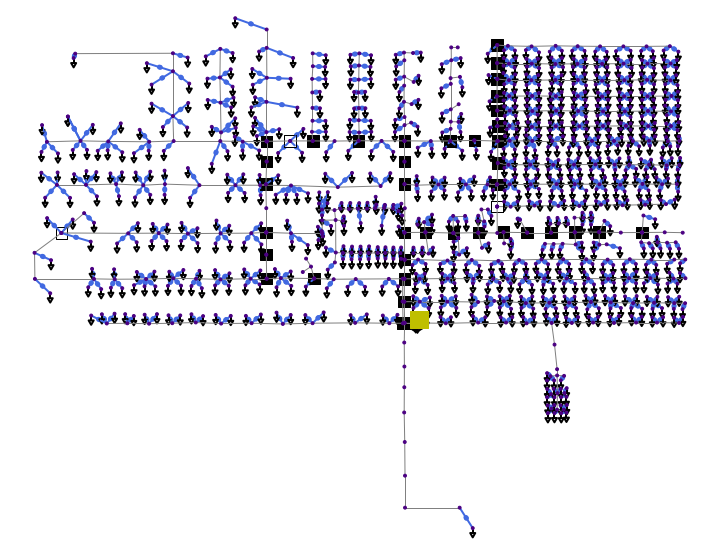

<AxesSubplot:>

In [ ]:
options = {
        "bus_size": 0.25,
        "plot_loads": True,
        "library": "networkx",
        "bus_color": "indigo",
        "switch_color": 'green',
        "trafo_color": 'royalblue',
        "load_size": 0.5, 
        "show_plot": True,
        "scale_size": True,
        "trafo_size": 0.25
    }
plt.figure(1, figsize=(50, 35))
pandaplot.simple_plot(pn, **options)

In [1060]:
import copy

pn2= copy.deepcopy(pn)

In [1061]:
pn2.switch.at[switches['switch302'], "closed"] = False
pn2.switch.at[switches['switch305'], "closed"] = False
pn2.switch.at[switches['switch65'], "closed"] = False

In [1062]:
#pn.bus[pn.bus.name== 'P_B247']['in_service'] = False
#pn.bus.at[buses['bus247'], "in_service"] = True
#pp.set_element_status(pn, 'P_B247', True)

In [1063]:
pp.runpp(pn2)

In [1064]:
pn2.load['total_consumption_ratio'] = pn2.res_load.p_mw/pn2.load.p_mw
#pn.asymmetric_load.head()
pn2.load.total_consumption_ratio.unique()

array([1., 0.])

In [1065]:
pn2.load['total_consumption_ratio'] = pn2.res_load.p_mw/pn2.load['p_mw']
pn2.load.head()
print(pn2.res_load.p_mw.unique())

[0.02  0.    0.01  0.25  0.3   0.03  0.15  0.045 0.075 0.225 0.09 ]


In [1066]:
print('Total single phase demand: ', round(pn2.res_load.sum(axis = 1).sum(),2), 'mw', '; Total three phase demand: ', round(pn2.res_asymmetric_load_3ph.sum(axis = 1).sum(),2), 'mw')

Total single phase demand:  24.3 mw ; Total three phase demand:  0.0 mw


In [1067]:
micropolis_buildings['power_consump_ratio'] = 'NA'
for index, row in micropolis_buildings.iterrows():
    micropolis_buildings.loc[index, 'power_consump_ratio'] = pn2.load[pn.load['name'] == 'P_LO{}'.format(row['ID'])]['total_consumption_ratio'].item()
micropolis_buildings.head()

,FACILITY_T,AREA,OHC,EF,CCN,HEIGHT,POP,ID,BUILDING_C,Category,Centroid,geometry,HubName,HubDist,type,Pabc,Qabc,voltage,phases,power_consump_ratio
0,Single Family Re,1502.34,7,1.5,1.0,14.0,1,1,114177.84,None,"3852,4329","POLYGON ((3870.889 4364.112, 3870.782 4349.179...",347,97.180446,Residential,20,0,120,1,1.0
1,Single Family Re,1534.68,7,1.5,1.0,14.0,1,2,116635.68,None,"3266,4061","POLYGON ((3240.796 4076.466, 3291.150 4076.466...",317,100.337214,Residential,20,0,120,1,1.0
2,Single Family Re,1512.22,7,1.0,1.0,14.0,2,3,114928.72,None,"3543,4082","POLYGON ((3525.126 4101.208, 3565.210 4101.155...",316,NaN,Residential,20,0,120,1,1.0
3,Single Family Re,1502.34,7,1.0,1.0,14.0,6,4,114177.84,None,"3399,4345","POLYGON ((3380.307 4310.097, 3380.549 4325.028...",325,102.018284,Residential,20,0,120,1,1.0
4,Single Family Re,1502.34,7,1.0,1.0,14.0,5,5,114177.84,None,"3249,4504","POLYGON ((3267.023 4539.468, 3267.034 4524.535...",325,114.257383,Residential,20,0,120,1,1.0


In [1068]:
micropolis_buildings.power_consump_ratio.unique()

array([1.0, 0.0], dtype=object)

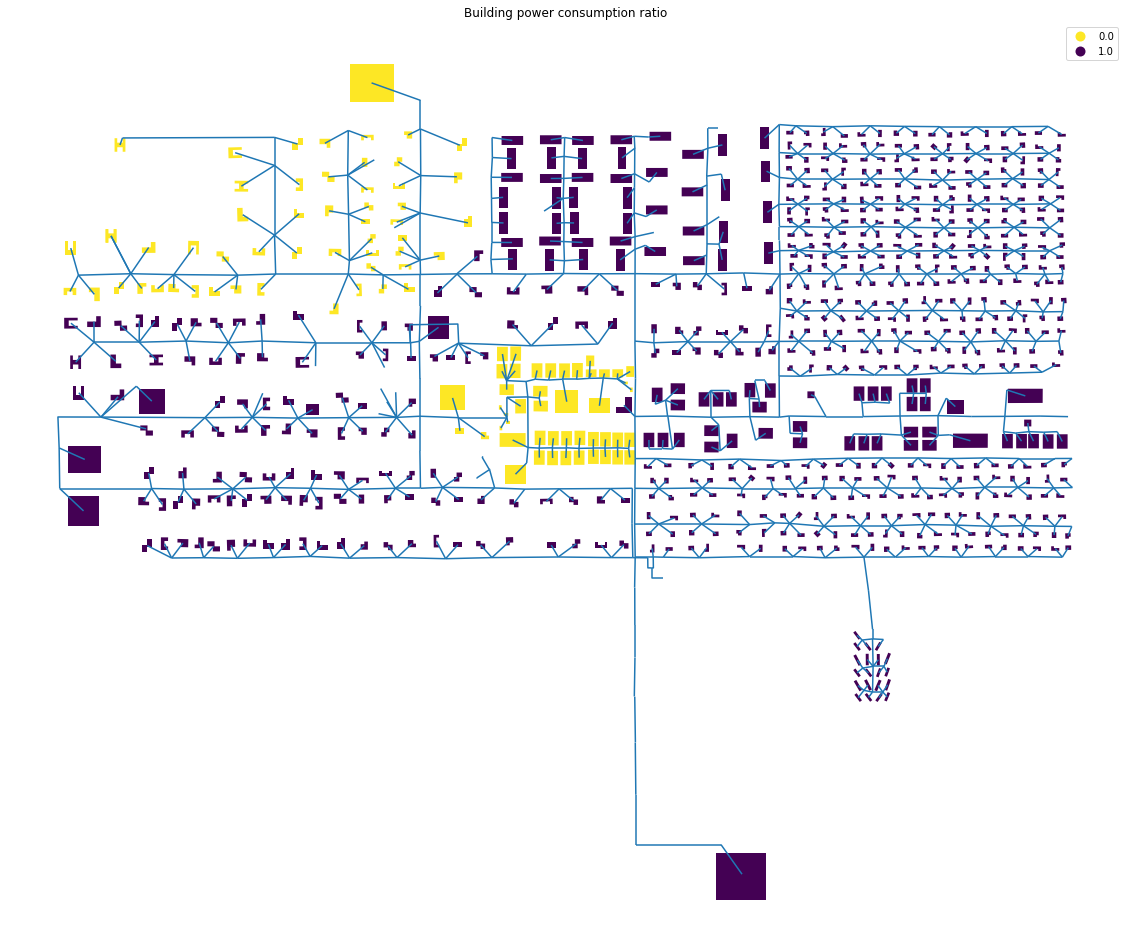

In [1069]:
#plotting
fig, ax = plt.subplots(figsize= (20,20)) 
micropolis_links.plot(ax = ax)
micropolis_hub_dist.plot(ax = ax)
micropolis_buildings.plot(ax = ax,
                          column='power_consump_ratio',
                          cmap='viridis_r',
                          categorical = False,
                          legend=True,
                          label = 'Consump'
)

ax.set(title='Building power consumption ratio')
ax.set_axis_off()

In [ ]:
pn.res_motor

,p_mw,q_mvar
0,0.23,0.1725
1,0.23,0.1725
2,0.23,0.1725


# Micropolis Traffic Network Generation

In [ ]:
nodes = gpd.read_file(micropolis_folder/'transpo_junctions.shp', encoding="utf-8")
nodes.id = 'T_J' + nodes.id.astype(str)
nodes['X'] = round(nodes.centroid.x, 0)
nodes['X'] = nodes['X'].astype(int)
nodes['Y'] = round(nodes.centroid.y,0)
nodes['Y'] = nodes['Y'].astype(int)
nodes.head()
#del nodes['geometry']

C:\Users\srijith\AppData\Local\Temp/ipykernel_1624/3272714342.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nodes['X'] = round(nodes.centroid.x, 0)
C:\Users\srijith\AppData\Local\Temp/ipykernel_1624/3272714342.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nodes['Y'] = round(nodes.centroid.y,0)


,id,Category,Attractor,geometry,X,Y
0,T_J1,Out-City,1,POINT (3601.466 1211.461),3601,1211
1,T_J2,Residentia,1,POINT (3602.095 3218.496),3602,3218
2,T_J3,CBD,1,POINT (3600.837 3601.537),3601,3602
3,T_J4,CBD,1,POINT (3604.611 3997.786),3605,3998
4,T_J5,CBD,1,POINT (3602.095 4422.968),3602,4423


In [ ]:
#Trip generation
generate_dict = {
    'Out-City': {'Out-City': [0, 100, 200],
                 'Residentia': [0, 0, 10, 20], 
                 'CBD': [0, 100, 200], 
                 'Outskirts': [0, 10, 15], 
                 'Industrial': [0, 100, 200], 
                 'Indus/CBD': [0, 100, 200]}, 
    'Residentia': {'Out-City': [0, 5, 10], 
                   'Residentia': [0, 0, 5], 
                   'CBD': [0, 10, 20], 
                   'Outskirts': [0, 5, 10], 
                   'Industrial': [0, 20, 50], 
                   'Indus/CBD': [0, 20, 30]}, 
    'CBD': {'Out-City': [0, 50, 100, 150], 
            'Residentia': [0, 5, 10], 
            'CBD': [0, 25, 50, 100], 
            'Outskirts': [0, 10, 20], 
            'Industrial': [0, 50 ,100], 
            'Indus/CBD': [0, 25, 50 , 100]}, 
    'Outskirts': {'Out-City': [0, 5, 10], 
                'Residentia': [0, 0, 5], 
                'CBD': [0, 10, 20],
                'Outskirts': [0, 0 , 10], 
                'Industrial': [0, 10, 20], 
                'Indus/CBD': [0, 10, 20]}, 
    'Industrial': {'Out-City': [0, 100, 150],
                   'Residentia': [0, 0, 5, 10], 
                   'CBD': [0, 50, 100], 
                   'Outskirts': [0, 0, 5, 10], 
                   'Industrial': [0, 100, 150], 
                   'Indus/CBD': [0, 50, 100]},
    'Indus/CBD': {'Out-City': [0, 50, 100], 
                  'Residentia': [0, 0, 5], 
                  'CBD': [0, 25, 50], 
                  'Outskirts': [0, 0, 5], 
                  'Industrial': [0, 50, 100], 
                  'Indus/CBD': [0, 25, 50]}
}

In [ ]:
#new attractor columns
attractor_nodes = nodes[nodes['Attractor'] == 1].id.unique()
for col in attractor_nodes:
    nodes[col] = 'NA'

In [ ]:
random.seed(30)
for origin_index, row in nodes.iterrows():
    origin_category = row['Category']
    for attractor_index, attractor in enumerate(attractor_nodes):
        attractor_category = nodes[nodes['id'] == attractor]['Category'].item()
        if row['id'] != attractor:
            nodes.loc[origin_index, attractor] = random.choice(generate_dict[origin_category][attractor_category])
        else:
            nodes.loc[origin_index, attractor] = 0
    print(origin_index, end = ", ")
nodes.head()

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 

,id,Category,Attractor,geometry,X,Y,T_J1,T_J2,T_J3,T_J4,...,T_J53,T_J54,T_J55,T_J56,T_J63,T_J64,T_J65,T_J66,T_J67,T_J68
0,T_J1,Out-City,1,POINT (3601.466 1211.461),3601,1211,0,10,200,0,...,0,200,100,200,0,20,10,0,100,100
1,T_J2,Residentia,1,POINT (3602.095 3218.496),3602,3218,5,0,20,0,...,5,0,20,20,0,0,0,50,5,10
2,T_J3,CBD,1,POINT (3600.837 3601.537),3601,3602,50,10,0,25,...,0,25,50,50,0,10,0,0,100,0
3,T_J4,CBD,1,POINT (3604.611 3997.786),3605,3998,100,5,0,0,...,5,0,100,25,5,5,10,0,100,100
4,T_J5,CBD,1,POINT (3602.095 4422.968),3602,4423,0,5,100,0,...,5,0,25,50,10,10,5,0,100,50


In [ ]:
total_flows = 0
for index, row in nodes.iterrows():
    print('Origin  {}'.format(row['id']))

    for i, attractor in enumerate(attractor_nodes):
        print('    {0} :    {1};'.format(attractor, nodes.loc[index, attractor]), end = '')
        total_flows += nodes.loc[index, attractor]
        
        if (i+1) % 5 == 0:
            print('')
    print('\n')
print(total_flows)

Origin  T_J1
    T_J1 :    0;    T_J2 :    10;    T_J3 :    200;    T_J4 :    0;    T_J5 :    200;
    T_J6 :    0;    T_J7 :    10;    T_J8 :    0;    T_J11 :    100;    T_J14 :    10;
    T_J15 :    200;    T_J17 :    0;    T_J18 :    0;    T_J19 :    100;    T_J25 :    0;
    T_J27 :    0;    T_J28 :    0;    T_J29 :    0;    T_J30 :    0;    T_J31 :    20;
    T_J38 :    10;    T_J41 :    0;    T_J42 :    20;    T_J47 :    0;    T_J48 :    0;
    T_J49 :    15;    T_J50 :    15;    T_J51 :    10;    T_J52 :    20;    T_J53 :    0;
    T_J54 :    200;    T_J55 :    100;    T_J56 :    200;    T_J63 :    0;    T_J64 :    20;
    T_J65 :    10;    T_J66 :    0;    T_J67 :    100;    T_J68 :    100;

Origin  T_J2
    T_J1 :    5;    T_J2 :    0;    T_J3 :    20;    T_J4 :    0;    T_J5 :    0;
    T_J6 :    0;    T_J7 :    5;    T_J8 :    5;    T_J11 :    0;    T_J14 :    0;
    T_J15 :    20;    T_J17 :    5;    T_J18 :    50;    T_J19 :    20;    T_J25 :    0;
    T_J27 :    5;    T_J

In [ ]:
#Node	X	Y	;
node_final = nodes[['id', 'X', 'Y']]
node_final.columns = ['Node', 'X', 'Y']
node_final.to_csv('../../infrarisk/data/networks/micropolis/transportation/nodes_final.csv', sep = '\t', index = False, line_terminator='\t;\n')
node_final.head()

,Node,X,Y
0,T_J1,3601,1211
1,T_J2,3602,3218
2,T_J3,3601,3602
3,T_J4,3605,3998
4,T_J5,3602,4423


## Links

In [ ]:
links = gpd.read_file(micropolis_folder/'transpo_links.shp', encoding="utf-8")
links['from'] = 'T_J' + links['from'].astype(str)
links.to = 'T_J' + links.to.astype(str)
links.Distance = links.Distance/1000
del links['geometry']
links.head()

,id,from,to,Category,Distance
0,1,T_J1,T_J2,Arterial,2.006092
1,2,T_J2,T_J3,Arterial,0.382412
2,3,T_J3,T_J4,Arterial,0.392319
3,4,T_J4,T_J5,Arterial,0.425184
4,5,T_J5,T_J6,Arterial,0.374873


In [ ]:
links_reverse = links.copy(deep=True)
links_reverse['id'] = range(len(links.id) + 1, 2*len(links.id) + 1)
links_reverse['from'] = links['to']
links_reverse['to'] = links['from']

links = links.append(links_reverse)
links.id = 'T_L' + links['id'].astype(str)
links.head()

,id,from,to,Category,Distance
0,T_L1,T_J1,T_J2,Arterial,2.006092
1,T_L2,T_J2,T_J3,Arterial,0.382412
2,T_L3,T_J3,T_J4,Arterial,0.392319
3,T_L4,T_J4,T_J5,Arterial,0.425184
4,T_L5,T_J5,T_J6,Arterial,0.374873


In [ ]:
link_dict = {
    'Arterial': {'Capacity': 900*3, 'Free Flow Speed': 50}, 
    'Subarteria': {'Capacity': 800*3, 'Free Flow Speed': 30},
    'Collectors': {'Capacity': 1500, 'Free Flow Speed': 25}
}
delay_dict = {
    'Out-City': 0, 
    'Residentia': 0.5, 
    'CBD': 2, 
    'Outskirts': 0.5, 
    'Industrial': 2,
    'Indus/CBD': 2
}

links['Capacity'] = links["Category"].apply(lambda x: link_dict.get(x)['Capacity'])
links['Free Flow Speed'] = links["Category"].apply(lambda x: link_dict.get(x)['Free Flow Speed'])
links['Free Flow Time1'] = 60*links['Distance']/ links['Free Flow Speed']

links['start_junc_type'] = 'NA'
for index, row in links.iterrows():
    links.loc[index, 'start_junc_type'] = nodes[nodes['id'] == row['from']].Category.values[0]

 
links['Delay'] = links["start_junc_type"].apply(lambda x: delay_dict.get(x))  
links['Free Flow Time'] = round(links['Free Flow Time1'] + links['Delay'],2)

links['B'] = 0.15
links['Power'] = 4
links['Speed limit'] = 0
links['Toll'] = 0
links['Type'] = 1

def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)


links_final = links[['from', 'to', 'Capacity', 'Distance', 'Free Flow Time', 	'B', 'Power', 'Speed limit', 'Toll', 'Type', 'id']]
links_final.columns = ['Init node',	'Term node', 'Capacity', 'Length', 'Free Flow Time',	'B', 'Power', 'Speed limit', 'Toll', 'Type', 'id']

links_final['sort_index'] = links_final['Init node'].apply(lambda x: find_number(x)).astype(int)
links_final = links_final.sort_values('sort_index')
del links_final['sort_index']

links_final.to_csv('../../infrarisk/data/networks/micropolis/transportation/links_final.csv', sep = '\t', index = False, line_terminator='\t;\n')

In [ ]:
math.cos(31.8, )

0.9271460038316639